# Projekt


źródło danych: https://www.kaggle.com/datasets/franciscogcc/financial-data 

Dane zawierają informacje z giełdowe.
Cel biznesowy: Zaprognozować cenę złota, w celu podjęcia decyzji o zakupie/ sprzedaży.

Opis danych:
- S&P 500 - SPDR S&P 500 ETF Trust
- Nasdaq 100 - Invesco QQQ ETF
- US Interest Rates - monthly federal rates
- CPI - Consumer Price Index, monthly
- USD / CHF forex rate
- EUR / USD forex rate
- GDP - Gross Domestic Product, trimonthly
- Silver - abrdn Physical Silver Shares ETF
- Oil - USO ETF
- Platinum - abrdn Physical Platinum Shares ETF
- Palladium - abrdn Physical Palladium Shares ETF
- Gold - SPDR Gold Trust ETF

Zadania do wykonania:
1. Wstępna analiza danych.
2. Uzupełnienie braków danych
3. Podział danych na klastry - jakie grupy przypadków obserwujemy?
4. Użycie głównych składowych do zmniejszenia liczby zmiennych.
5. Podział danych na train/ test
6. Stworzenie modelu time series
7. Stworzenie modelu ML i porównanie wyników
8. *Stworzenie modelu, który dokona predykcji na za 7 dni. (Możesz wybrać inną jednostkę).

Zmienna celu: gold close

Dla chętnych: stworzenie modelu ML z wieloklasowym wyjściem: wyznaczamy cenę otwarcia, zamknięcia oraz najwyższą/ najniższą


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/financial_regression.csv')

1. Wstępna analiza danych.

In [3]:
import matplotlib.pyplot as plt

In [ ]:
df.head()

In [ ]:
df.info()

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.select_dtypes(include='float').corr().sort_values(by='gold close')['gold close']

In [ ]:
plt.plot(df['date'],df['gold close'])
plt.title('Cena zamkniecia zlota')
plt.show()

2. Uzupełnienie braków danych


In [11]:
df.set_index('date', inplace=True)

In [12]:
df = df.resample('D').mean()

In [ ]:
df.head(10)

In [14]:
df_interpolate = df.interpolate('time',limit=10000)

In [ ]:
df_interpolate.isna().max()

In [ ]:
df_interpolate.isna().sum()

In [ ]:
df_interpolate.loc[:,'CPI']

In [18]:
df_interpolate = df_interpolate.bfill()

In [ ]:
df_interpolate.isna().max()

In [ ]:
df_interpolate.isna().max().max()

3. Podział danych na klastry - jakie grupy przypadków obserwujemy?


In [21]:
from sklearn.preprocessing import scale
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [ ]:
df_scaled = pd.DataFrame(data = scale(df_interpolate), columns = df_interpolate.columns)
df_scaled.head()

In [ ]:
df_scaled.describe()

In [ ]:
clusters = np.arange(2,11,1)
clusters

In [ ]:
df_scaled.columns

In [27]:
features_to_cluster = [i for i in df_scaled.columns if 'open' in i] + [ 'us_rates_%', 'CPI',
       'usd_chf', 'eur_usd', 'GDP']

In [ ]:
features_to_cluster

In [30]:
scores = []
for i in clusters:
    k_means = KMeans(n_clusters=i, random_state=123).fit(df_scaled[features_to_cluster])
    scores.append(silhouette_score(df_scaled[features_to_cluster],k_means.labels_))

In [ ]:
plt.plot(clusters,scores)
plt.title('Silhouette score dla poszczególnej liczby klastrów')
plt.show()

In [ ]:
chosen_cluster = clusters[scores.index(max(scores))]
chosen_cluster

In [34]:
k_means = KMeans(n_clusters=chosen_cluster,random_state=123).fit(df_scaled[features_to_cluster])
df_interpolate['cluster'] = k_means.labels_

In [35]:
gold_features = [i for i in df_interpolate.columns if 'gold' in i]

In [ ]:
sns.pairplot(df[gold_features + ['cluster']], hue = 'cluster')
plt.show()

4. Użycie głównych składowych do zmniejszenia liczby zmiennych.


In [37]:
from sklearn.decomposition import PCA

In [43]:
df.columns

Index(['sp500 open', 'sp500 high', 'sp500 low', 'sp500 close', 'sp500 volume',
       'sp500 high-low', 'nasdaq open', 'nasdaq high', 'nasdaq low',
       'nasdaq close', 'nasdaq volume', 'nasdaq high-low', 'us_rates_%', 'CPI',
       'usd_chf', 'eur_usd', 'GDP', 'silver open', 'silver high', 'silver low',
       'silver close', 'silver volume', 'silver high-low', 'oil open',
       'oil high', 'oil low', 'oil close', 'oil volume', 'oil high-low',
       'platinum open', 'platinum high', 'platinum low', 'platinum close',
       'platinum volume', 'platinum high-low', 'palladium open',
       'palladium high', 'palladium low', 'palladium close',
       'palladium volume', 'palladium high-low', 'gold open', 'gold high',
       'gold low', 'gold close', 'gold volume', 'cluster'],
      dtype='object')

In [42]:
x = [i for i in df.columns if 'open' in i and 'gold' not in i] + ['us_rates_%', 'CPI',
       'usd_chf', 'eur_usd', 'GDP']
x

['sp500 open',
 'nasdaq open',
 'silver open',
 'oil open',
 'platinum open',
 'palladium open',
 'us_rates_%',
 'CPI',
 'usd_chf',
 'eur_usd',
 'GDP']

In [44]:
pca = PCA().fit(df_scaled[x])

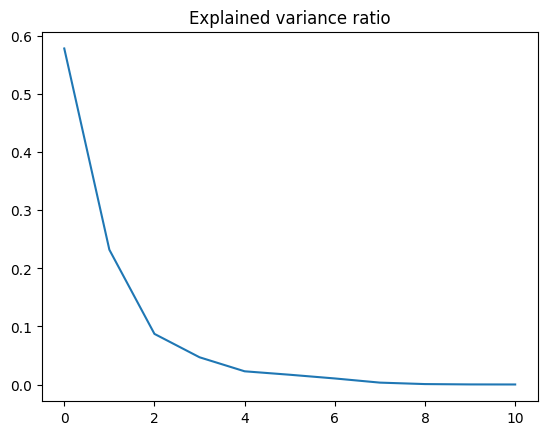

In [45]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Explained variance ratio')
plt.show()

In [46]:
pca.explained_variance_ratio_

array([5.78553756e-01, 2.32156961e-01, 8.72541841e-02, 4.69923458e-02,
       2.28627370e-02, 1.69434471e-02, 1.05429893e-02, 3.36954087e-03,
       8.70766914e-04, 2.76220499e-04, 1.77052061e-04])

In [47]:
columns_pca = [f'pca_{i}' for i in range(len(x)) ]
columns_pca

['pca_0',
 'pca_1',
 'pca_2',
 'pca_3',
 'pca_4',
 'pca_5',
 'pca_6',
 'pca_7',
 'pca_8',
 'pca_9',
 'pca_10']

In [48]:
df_pca = pd.DataFrame(pca.transform(df_scaled[x]), columns = columns_pca)

In [50]:
df_to_train = df_pca[columns_pca[:3]].copy()

In [51]:
df_to_train.loc[:,'date'] = df_interpolate.index.copy()

In [52]:
df_to_train.set_index('date', inplace = True)
df_to_train['y'] = df_interpolate['gold close']
df_to_train.head()

,pca_0,pca_1,pca_2,y
date,,,,
2010-01-14,-3.627807,0.247963,-0.712306,112.030
2010-01-15,-3.615665,0.160358,-0.715375,110.860
2010-01-16,-3.619222,0.134815,-0.718421,111.025
2010-01-17,-3.622779,0.109272,-0.721466,111.190
2010-01-18,-3.626336,0.083729,-0.724511,111.355


5. Podział danych na train/ test

In [54]:
date_train = df.index.max() - pd.Timedelta(365,unit='D')
date_train

Timestamp('2023-10-24 00:00:00')

In [55]:
df_to_train = df_to_train.reset_index().rename(columns={'date':'ds'})

In [56]:
train = df_to_train[df_to_train['ds']<=date_train]
test = df_to_train[df_to_train['ds']>date_train]

6. Stworzenie modelu time series


In [57]:
from neuralprophet import NeuralProphet

In [58]:
model = NeuralProphet()

In [59]:
train.columns

Index(['ds', 'pca_0', 'pca_1', 'pca_2', 'y'], dtype='object')

In [60]:
for i in train.columns[1:4]:
    model.add_future_regressor(i)
    print(i)

pca_0
pca_1
pca_2


In [61]:
model.fit(train,freq = 'D')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.98% of the data.
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be 

Finding best initial lr:   0%|          | 0/242 [00:00<?, ?it/s]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return tor

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,173.437515,188.806595,1.542961,0.0,0
1,78.423225,96.683250,0.608798,0.0,1
2,28.364168,37.407764,0.156998,0.0,2
3,17.547424,23.925295,0.074469,0.0,3
4,11.786348,15.994947,0.038924,0.0,4
...,...,...,...,...,...
65,4.269257,5.412844,0.005825,0.0,65
66,4.262691,5.419034,0.005802,0.0,66
67,4.259646,5.405123,0.005796,0.0,67
68,4.249434,5.411809,0.005802,0.0,68


In [62]:
forecast = model.predict(df_to_train)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.981% of the data.
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col

Predicting: 79it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [63]:
forecast.head()

,ds,y,yhat1,trend,season_yearly,season_weekly,future_regressors_additive,future_regressor_pca_0,future_regressor_pca_1,future_regressor_pca_2
0,2010-01-14,112.030,118.327339,97.610825,-0.608568,-0.092364,21.417444,-0.008859,21.886816,-0.460512
1,2010-01-15,110.860,117.867699,97.633797,-0.562327,0.048908,20.747320,-0.060417,21.266882,-0.459145
2,2010-01-16,111.025,117.815231,97.656776,-0.519899,0.095330,20.583025,-0.045313,21.086126,-0.457788
3,2010-01-17,111.190,117.714066,97.679749,-0.481349,0.096925,20.418736,-0.030209,20.905376,-0.456432
4,2010-01-18,111.355,117.354019,97.702728,-0.446708,-0.156446,20.254444,-0.015104,20.724625,-0.455075


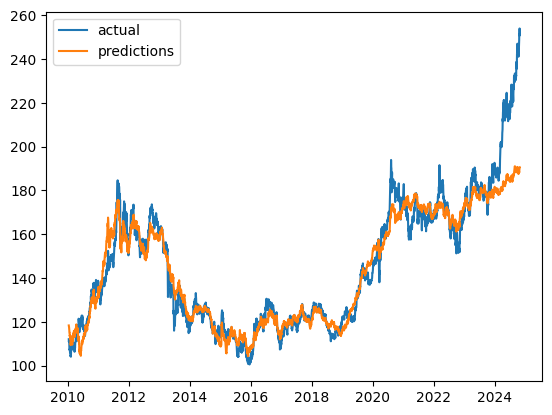

In [64]:
plt.plot(forecast['ds'],forecast['y'], label = 'actual')
plt.plot(forecast['ds'], forecast['yhat1'], label ='predictions')
plt.legend()
plt.show()

In [76]:
df_to_train['gold open'] = df_interpolate.reset_index()['gold open'].copy()

In [77]:
df_to_train.head()

,ds,pca_0,pca_1,pca_2,y,gold open
0,2010-01-14,-3.627807,0.247963,-0.712306,112.030,111.51
1,2010-01-15,-3.615665,0.160358,-0.715375,110.860,111.35
2,2010-01-16,-3.619222,0.134815,-0.718421,111.025,111.25
3,2010-01-17,-3.622779,0.109272,-0.721466,111.190,111.15
4,2010-01-18,-3.626336,0.083729,-0.724511,111.355,111.05


In [70]:
model_2 = NeuralProphet()

In [79]:
train = df_to_train[df_to_train['ds']<=date_train]
test = df_to_train[df_to_train['ds']>date_train]

In [72]:
train.columns

Index(['ds', 'pca_0', 'pca_1', 'pca_2', 'y', 'gold open'], dtype='object')

In [73]:
for i in train.columns[1:4]:
    model_2.add_future_regressor(i)
    print(i)

pca_0
pca_1
pca_2


In [74]:
model_2.add_future_regressor('gold open')

In [80]:
model_2.fit(train,freq='D')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.98% of the data.
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be 

Finding best initial lr:   0%|          | 0/242 [00:00<?, ?it/s]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return tor

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,56.391571,71.122246,0.391642,0.0,0
1,27.880531,37.335766,0.148020,0.0,1
2,11.274025,14.971575,0.035906,0.0,2
3,6.065299,7.497430,0.010242,0.0,3
4,4.799622,5.811633,0.006206,0.0,4
...,...,...,...,...,...
65,0.595641,0.866820,0.000151,0.0,65
66,0.598877,0.866899,0.000152,0.0,66
67,0.596647,0.868552,0.000151,0.0,67
68,0.592842,0.860792,0.000150,0.0,68


In [81]:
forecast_m2 = model_2.predict(df_to_train)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.981% of the data.
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col

Predicting: 79it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


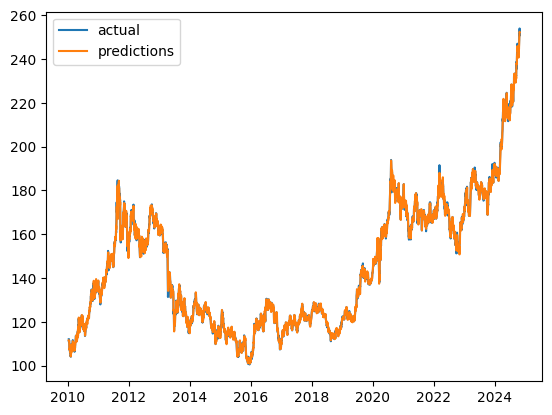

In [82]:
plt.plot(forecast_m2['ds'],forecast_m2['y'], label = 'actual')
plt.plot(forecast_m2['ds'], forecast_m2['yhat1'], label ='predictions')
plt.legend()
plt.show()

7. Stworzenie modelu ML i porównanie wyników

In [83]:
df_to_train.head()

,ds,pca_0,pca_1,pca_2,y,gold open
0,2010-01-14,-3.627807,0.247963,-0.712306,112.030,111.51
1,2010-01-15,-3.615665,0.160358,-0.715375,110.860,111.35
2,2010-01-16,-3.619222,0.134815,-0.718421,111.025,111.25
3,2010-01-17,-3.622779,0.109272,-0.721466,111.190,111.15
4,2010-01-18,-3.626336,0.083729,-0.724511,111.355,111.05


In [84]:
df_to_train['month'] = df_to_train['ds'].dt.month
df_to_train['day'] = df_to_train['ds'].dt.day
df_to_train['quarter'] = df_to_train['ds'].dt.quarter

In [86]:
df_to_train['y_diff'] = df_to_train['y'].diff()

In [87]:
df_to_train.head()

,ds,pca_0,pca_1,pca_2,y,gold open,month,day,quarter,y_diff
0,2010-01-14,-3.627807,0.247963,-0.712306,112.030,111.51,1,14,1,NaN
1,2010-01-15,-3.615665,0.160358,-0.715375,110.860,111.35,1,15,1,-1.170
2,2010-01-16,-3.619222,0.134815,-0.718421,111.025,111.25,1,16,1,0.165
3,2010-01-17,-3.622779,0.109272,-0.721466,111.190,111.15,1,17,1,0.165
4,2010-01-18,-3.626336,0.083729,-0.724511,111.355,111.05,1,18,1,0.165


In [88]:
df_to_train_2 = df_to_train.dropna()

In [89]:
train = df_to_train_2[df_to_train_2['ds']<=date_train]
test = df_to_train_2[df_to_train_2['ds']>date_train]

In [90]:
from sklearn.tree import DecisionTreeRegressor

In [94]:
base_x = ['pca_0','pca_1','pca_2','month','quarter','day']

In [103]:
x_y_names = [[base_x +['gold open'],'y'],[base_x,'y_diff'],[base_x +['gold open'],'y_diff']]

[['pca_0', 'pca_1', 'pca_2', 'month', 'quarter', 'day', 'gold open'], 'y']


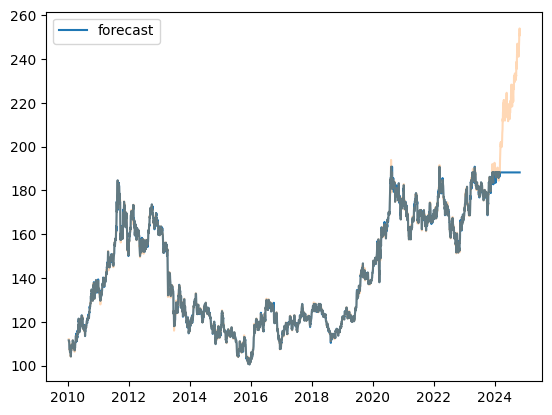

[['pca_0', 'pca_1', 'pca_2', 'month', 'quarter', 'day'], 'y_diff']


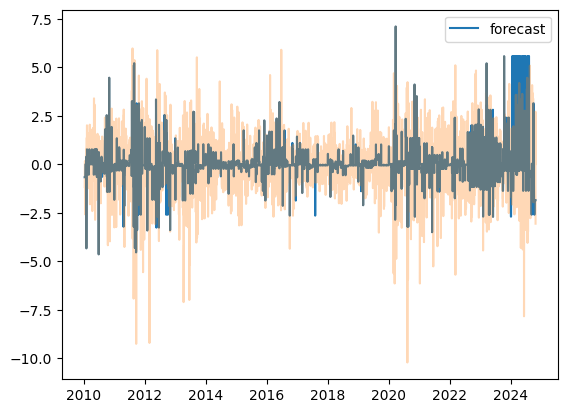

[['pca_0', 'pca_1', 'pca_2', 'month', 'quarter', 'day', 'gold open'], 'y_diff']


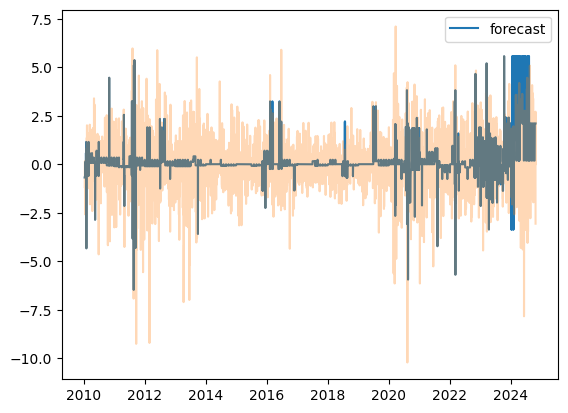

In [109]:
for i in x_y_names:
    print(i)
    train_x = train[i[0]]
    train_y = train[i[1]]
    model = DecisionTreeRegressor(max_depth=20, min_samples_split=10).fit(train_x,train_y)
    pred = pd.Series(model.predict(df_to_train[i[0]]))
    pred.index = df_to_train.ds
    plt.plot(pred,label = 'forecast')
    plt.plot(df_to_train['ds'],df_to_train[i[1]],alpha = 0.3)
    plt.legend()
    plt.show()

8. *Stworzenie modelu, który dokona predykcji na za 7 dni. (Możesz wybrać inną jednostkę).

In [110]:
from sklearn.linear_model import QuantileRegressor

In [112]:
df_to_train = df_to_train.sort_values(by='ds')
df_to_train['y_new'] = df_to_train['y'].shift(-7)

In [113]:
df_to_train.head(10)

,ds,pca_0,pca_1,pca_2,y,gold open,month,day,quarter,y_diff,y_new
0,2010-01-14,-3.627807,0.247963,-0.712306,112.030000,111.51,1,14,1,NaN,107.370000
1,2010-01-15,-3.615665,0.160358,-0.715375,110.860000,111.35,1,15,1,-1.170000,107.170000
2,2010-01-16,-3.619222,0.134815,-0.718421,111.025000,111.25,1,16,1,0.165000,107.273333
3,2010-01-17,-3.622779,0.109272,-0.721466,111.190000,111.15,1,17,1,0.165000,107.376667
4,2010-01-18,-3.626336,0.083729,-0.724511,111.355000,111.05,1,18,1,0.165000,107.480000
5,2010-01-19,-3.629893,0.058186,-0.727556,111.520000,110.95,1,19,1,0.165000,107.560000
6,2010-01-20,-3.612170,-0.100847,-0.764604,108.940000,109.97,1,20,1,-2.580000,106.528000
7,2010-01-21,-3.592635,-0.137417,-0.759061,107.370000,108.48,1,21,1,-1.570000,106.480000
8,2010-01-22,-3.565657,-0.268341,-0.772746,107.170000,106.93,1,22,1,-0.200000,105.960000
9,2010-01-23,-3.568631,-0.277995,-0.772594,107.273333,107.10,1,23,1,0.103333,106.756667


In [114]:
train = df_to_train[df_to_train['ds']<=date_train]
test = df_to_train[df_to_train['ds']>date_train]

In [117]:
x_names =  base_x[:3] + ['gold open']

In [118]:
mq = QuantileRegressor(quantile=0.5).fit(train[x_names], train['y_new'])

In [119]:
pred_mq = pd.Series(mq.predict(df_to_train[x_names]))

In [121]:
pred_mq.index = df_to_train.ds

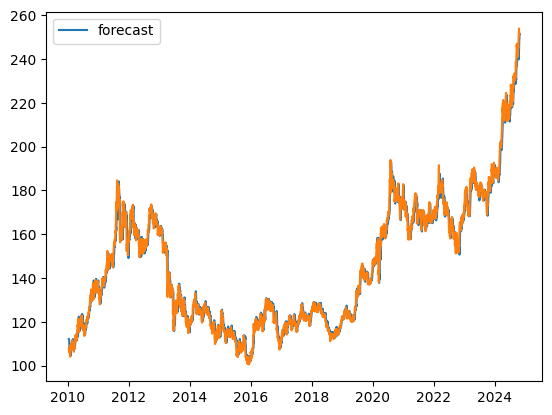

In [122]:
plt.plot(pred_mq, label='forecast')
plt.plot(df_to_train['ds'],df_to_train['y_new'])
plt.legend()
plt.show()
